# Glove embedding and best models

- Daniel Branco, 20220599
- Fernando Cruz, 20220646
- Inês Ventura, 20220612
- Maria Mendonça, 20220625

In [3]:
import pandas as pd
import requests
import zipfile
import os
import numpy as np
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tokenizers import Tokenizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Flatten, BatchNormalization, Activation, Bidirectional, Masking
from numpy import zeros


In [9]:
import pickle
with open('/content/drive/MyDrive/Text Mining/preprocessed_train_df.pickle', 'rb') as data:
    reviews_preprocessed = pickle.load(data)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pickle
with open('/content/drive/MyDrive/Text Mining/preprocessed_airbnb_df_train.pickle', 'rb') as data:
    airbnb_preprocessed = pickle.load(data)

In [6]:
%cd /content/drive/MyDrive/Text Mining/
airbnb_df_train = pd.read_excel('train.xlsx')
airbnb_df_test = pd.read_excel('test.xlsx')

reviews_df_train = pd.read_excel('train_reviews.xlsx')
reviews_df_test = pd.read_excel('test_reviews.xlsx')

/content/drive/.shortcut-targets-by-id/1N9Y-dcZIQh9qUPRXgB1grO-NTXypIRl8/Text Mining


In [ ]:
reviews_preprocessed.head(10)

,apartment_id,comments,word_count,language,sentiment
0,1,"[cozy, comfortable, house, stay, in.never, wor...",28,en,positive
1,5,"[bel, appartemer, magnifique, vue, plage, mer,...",47,fr,positive
2,8,"[shani, helpful, process, thank, answer, fast,...",17,en,positive
3,9,"[passer, bon, séjour, isabel, helder, appartem...",72,fr,positive
4,10,"[wow, great, stay, spacious, apartment, brand,...",133,en,positive
5,11,"[cristina, perfect, host, help, lot, trip, hou...",63,en,positive
6,12,"[faltando, cerca, dia, viagem, contactar, info...",89,pt,neutral
7,14,"[amazing, place, heart, barrio, alto, authenti...",102,en,positive
8,16,"[try, reply, website, come, shall, try, way, r...",81,en,positive
9,19,"[casa, pequeño, acogedoro, anfitrión, encantad...",52,es,positive


In [ ]:
airbnb_preprocessed.head()

,description,description_language,host_about,host_about_language,index,unlisted
0,"[joli, appartemer, bordure, mer, min, pied, pl...",fr,"[être, famille, enfant, an, habiter, année, po...",fr,5.0,0.0
1,"[apartamento, charmoso, chiado, largo, carmo, ...",pt,"[hello, m, portuguese, love, meet, people, wor...",en,4.0,0.0
2,"[dear, guest, pleaser, receive, home, guest, r...",en,"[quiet, person, like, cinema, reading, writing...",en,11.0,0.0
3,"[walk, original, wooden, stair, entrance, apar...",en,"[service, holiday, apartment, casa, azenhas, m...",en,10.0,0.0
4,"[espaço, ficar, parque, eduardo, vii, saldanha...",pt,"[friendly, host, try, need, quit, strict, hous...",en,2.0,1.0


## **Merged - reviews, description and host_about preprocessed**

In [10]:
# Group the 'reviews_preprocessed' DataFrame by 'apartment_id' and aggregate the columns as lists
reviews_grouped = reviews_preprocessed.groupby('apartment_id').agg({
    'comments': list,
    'word_count': list,
    'sentiment': list,
    'language': list
}).reset_index()

reviews_grouped['comments'] = reviews_grouped['comments'].apply(lambda x: [item for sublist in x for item in sublist])

merged_train = pd.merge(reviews_grouped, airbnb_preprocessed, left_on='apartment_id', right_on='index', how='right')

# Fill missing values with empty lists
merged_train.fillna('', inplace=True)

# Set 'apartment_id' as the index
merged_train.set_index('apartment_id', inplace=True)
merged_train.drop('index', axis=1, inplace=True)

In [ ]:
merged_train.head(10)

,comments,word_count,sentiment,language,description,description_language,host_about,host_about_language,unlisted
apartment_id,,,,,,,,,
5.0,"[bel, appartemer, magnifique, vue, plage, mer,...","[47, 34, 35, 27, 111, 18, 23]","[positive, positive, positive, neutral, positi...","[fr, fr, es, pt, de, de, en]","[joli, appartemer, bordure, mer, min, pied, pl...",fr,"[être, famille, enfant, an, habiter, année, po...",fr,0.0
,,,,,"[apartamento, charmoso, chiado, largo, carmo, ...",pt,"[hello, m, portuguese, love, meet, people, wor...",en,0.0
11.0,"[cristina, perfect, host, help, lot, trip, hou...","[63, 91, 27, 28, 63, 58, 53]","[positive, positive, positive, positive, posit...","[en, fr, en, en, en, ru, en]","[dear, guest, pleaser, receive, home, guest, r...",en,"[quiet, person, like, cinema, reading, writing...",en,0.0
10.0,"[wow, great, stay, spacious, apartment, brand,...","[133, 215, 50, 14, 14, 74, 56]","[positive, positive, positive, positive, posit...","[en, en, en, en, de, en, en]","[walk, original, wooden, stair, entrance, apar...",en,"[service, holiday, apartment, casa, azenhas, m...",en,0.0
,,,,,"[espaço, ficar, parque, eduardo, vii, saldanha...",pt,"[friendly, host, try, need, quit, strict, hous...",en,1.0
1.0,"[cozy, comfortable, house, stay, in.never, wor...","[28, 261, 81, 27, 42, 12, 74]","[positive, positive, positive, positive, posit...","[en, en, de, en, en, en, en]","[share, mixed, room, hostel, share, bathroom, ...",en,"[alojamento, registro, /al]",pt,0.0
14.0,"[amazing, place, heart, barrio, alto, authenti...","[102, 166, 109, 40, 8, 93, 16]","[positive, positive, positive, positive, posit...","[en, es, fr, en, en, en, en]","[luxurious, romantic, home, away, home!new, br...",en,"[patrick, i´m, airbnb, member, live, amsterdam...",en,0.0
,,,,,"[important, response, covid-, property, extend...",en,"[hi, home, company, develop, activity, tourism...",en,0.0
,,,,,"[proprietário, receber, hospede, pessoalmente,...",pt,"[receber, hospede, sintar, casa]",pt,0.0


## Train Test Split

In [11]:
merged_train['comments'] = merged_train['comments'].apply(lambda tokens: ' '.join(tokens))
merged_train['host_about'] = merged_train['host_about'].apply(lambda tokens: ' '.join(tokens))
merged_train['description'] = merged_train['description'].apply(lambda tokens: ' '.join(tokens))
merged_train['sentiment'] = merged_train['sentiment'].apply(lambda tokens: ' '.join(tokens))


# Split your data into train and test sets
X = merged_train['comments'] + merged_train['host_about'] + merged_train['description'] + merged_train['sentiment']
y = merged_train['unlisted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
X

apartment_id
5.0        bel appartemer magnifique vue plage mer minute...
           hello m portuguese love meet people word s may...
11.0       cristina perfect host help lot trip house clea...
10.0       wow great stay spacious apartment brand new su...
           friendly host try need quit strict house rulee...
                                 ...                        
12493.0    nice place nice location easy communication lo...
12486.0    great property functional locate great restaur...
12488.0    être accueillir arrivée tardif lieux carla ami...
12492.0    appartement bien situer plein coeur bairro alt...
           blueground global proptech company thousand re...
Length: 11970, dtype: object

## Load the GloVe Word Vectors


In [12]:

# Download the GloVe word vectors
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
filename = 'glove.6B.zip'
response = requests.get(url, stream=True)

with open(filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)

# Extract the GloVe word vectors
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

# Remove the zip file
os.remove(filename)

In [13]:
# Load the word vectors into a dictionary
glove_file = 'glove.6B.100d.txt'
embeddings_dict = dict()
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = vec

print(f'Loaded {len(embeddings_dict)} word vectors')

Loaded 400000 word vectors


## GloVe Embeddings

In [14]:
# Convert the input data to strings
X_train = X_train.astype(str)
X_test = X_test.astype(str)

max_features=10000

word_tokenizer = Tokenizer(num_words=max_features)
word_tokenizer.fit_on_texts(X_train.tolist())
X_train = word_tokenizer.texts_to_sequences(X_train.tolist())
X_test = word_tokenizer.texts_to_sequences(X_test.tolist())

# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1

# Padding all reviews to fixed length 100
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [15]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Print Embedding Matrix shape
embedding_matrix.shape

(67792, 100)

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.98492998, -0.13416   ,  0.25951001, ...,  0.15956999,
         0.3761    , -0.59745002],
       [ 0.43384999,  0.39656001, -0.08207   , ..., -0.32477   ,
        -0.15831   ,  0.67786998],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## LSTM

### Training the model

In [16]:
# Neural Network architecture
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))

# Model compiling
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model.summary())

# Model Training
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          6779200   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 6,896,577
Trainable params: 117,377
Non-trainable params: 6,779,200
_________________________________________________________________
None
Epoch 1/6
46/46 [==============================] - 10s 25ms/step - loss: 0.3864 - accuracy: 0.8293 - val_loss: 0.3643 - val_accuracy: 0.8496
Epoch 2/6
46/46 [==============================] - 1s 12ms/step - loss: 0.3608 - accuracy: 0.8513 - val_loss: 0.3627 - val_accuracy: 0.8496
Epoch 3/6
46/46 [=

### Evaluation and Results

113/113 [==============================] - 0s 4ms/step - loss: 0.3539 - accuracy: 0.8596
Test Score: 0.35387465357780457
Test Accuracy: 0.859649121761322


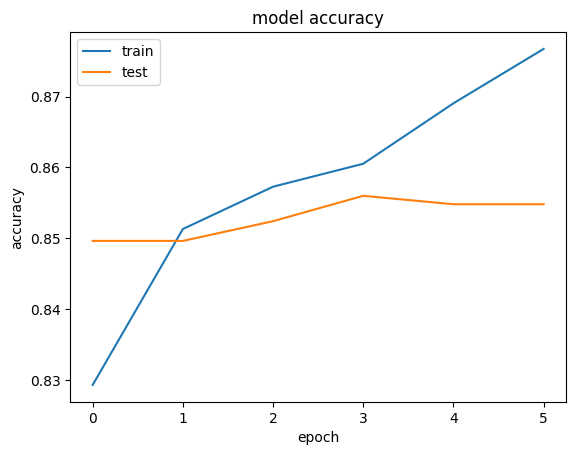

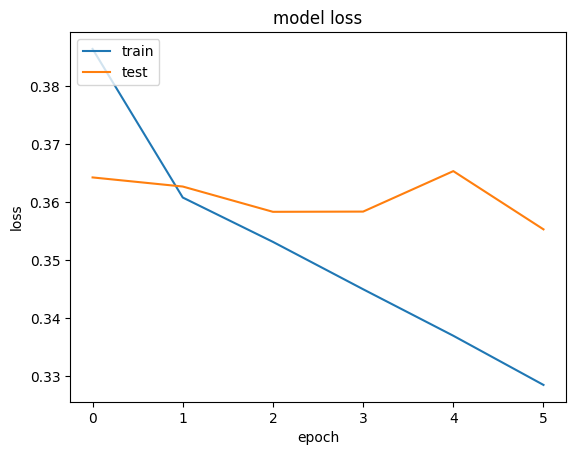

In [17]:
# Predictions on the Test Set
score = lstm_model.evaluate(X_test, y_test, verbose=1)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

# Model Performance Charts
plt.plot(lstm_model_history.history['accuracy'])
plt.plot(lstm_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
X_test

array([[  68,   90, 1765, ...,   17,  108,  840],
       [ 983,    3, 2026, ...,    0,    0,    0],
       [  24, 1150,   12, ...,    2,  155,    2],
       ...,
       [ 177,   23,    1, ...,    0,    0,    0],
       [ 707, 1710, 1352, ...,    2,    2,    2],
       [ 134,   14,  301, ...,    2,    2,    2]], dtype=int32)

113/113 [==============================] - 1s 3ms/step


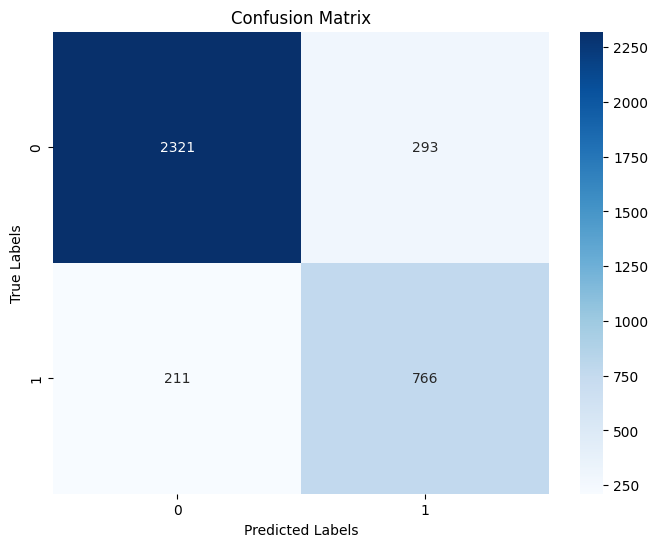

In [18]:
# Make predictions
predictions = lstm_model.predict(X_test)

threshold = 0.5
binary_predictions = np.where(predictions >= threshold, 1, 0)

# Create a confusion matrix
cm = confusion_matrix(y_test, binary_predictions)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [20]:
print(classification_report(y_test, binary_predictions))

              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90      2614
         1.0       0.72      0.78      0.75       977

    accuracy                           0.86      3591
   macro avg       0.82      0.84      0.83      3591
weighted avg       0.86      0.86      0.86      3591



## Logistic Regression

### Training the model

In [21]:
# Convert the input data to strings
X_train_str = [" ".join(map(str, sequence)) for sequence in X_train]
X_test_str = [" ".join(map(str, sequence)) for sequence in X_test]

# Convert text data to numerical features using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_str)
X_test_vectorized = vectorizer.transform(X_test_str)

# Train logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_vectorized, y_train)

# Make predictions
predictions = logreg.predict(X_test_vectorized)


### Evaluation and Results

In [22]:
# Calculate accuracy
accuracy = logreg.score(X_test_vectorized, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.809245335561125


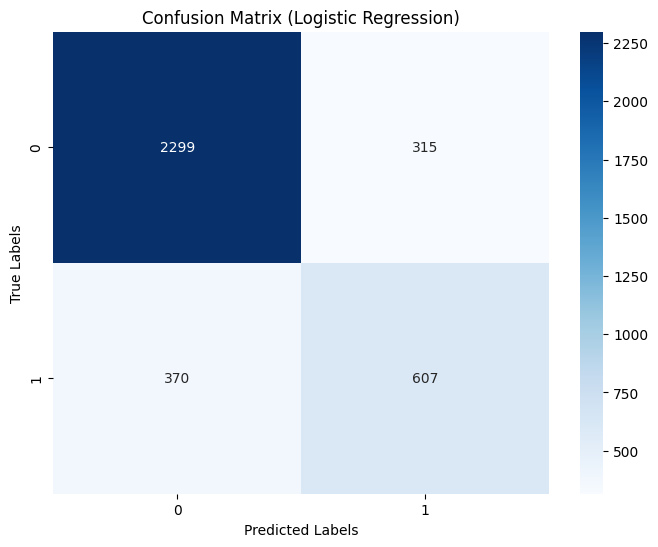

In [23]:
# Set a threshold for converting predictions to binary values
threshold = 0.5
binary_predictions = np.where(predictions >= threshold, 1, 0)

# Create a confusion matrix
cm = confusion_matrix(y_test, binary_predictions)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [24]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87      2614
         1.0       0.66      0.62      0.64       977

    accuracy                           0.81      3591
   macro avg       0.76      0.75      0.75      3591
weighted avg       0.81      0.81      0.81      3591



## MLP

### Training the model

In [25]:
# MLP Model architecture with Embedding layer
mlp_model = Sequential()
mlp_model.add(Embedding(vocab_length, 100, input_length=maxlen, trainable=False))
mlp_model.add(Flatten())
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(32, activation='relu'))
mlp_model.add(Dropout(0.1))
mlp_model.add(Dense(1, activation='sigmoid'))

# Model compiling
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
print(mlp_model.summary())

# Model Training
mlp_model_history = mlp_model.fit(X_train, y_train, batch_size=16, epochs=5, verbose=1, validation_split=0.3)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          6779200   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

### Evaluation and Results

113/113 [==============================] - 0s 2ms/step - loss: 0.7382 - binary_accuracy: 0.8396
Test Score: 0.738235354423523
Test Accuracy: 0.8395990133285522


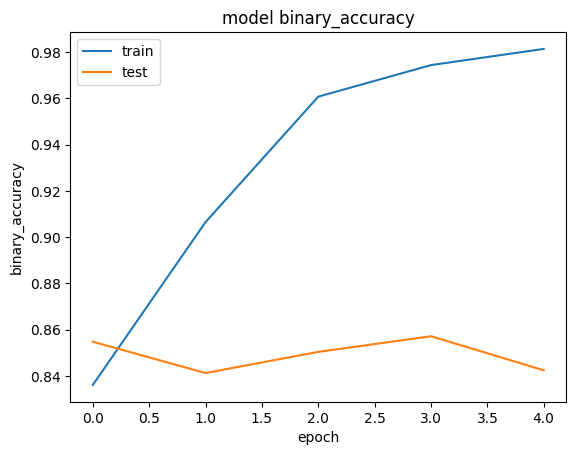

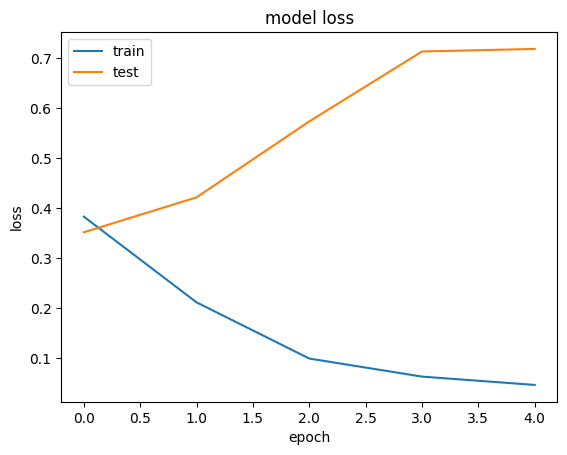

In [26]:
# Predictions on the Test Set
score = mlp_model.evaluate(X_test, y_test, verbose=1)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

# Model Performance Charts
plt.plot(mlp_model_history.history['binary_accuracy'])
plt.plot(mlp_model_history.history['val_binary_accuracy'])
plt.title('model binary_accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(mlp_model_history.history['loss'])
plt.plot(mlp_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

113/113 [==============================] - 0s 2ms/step


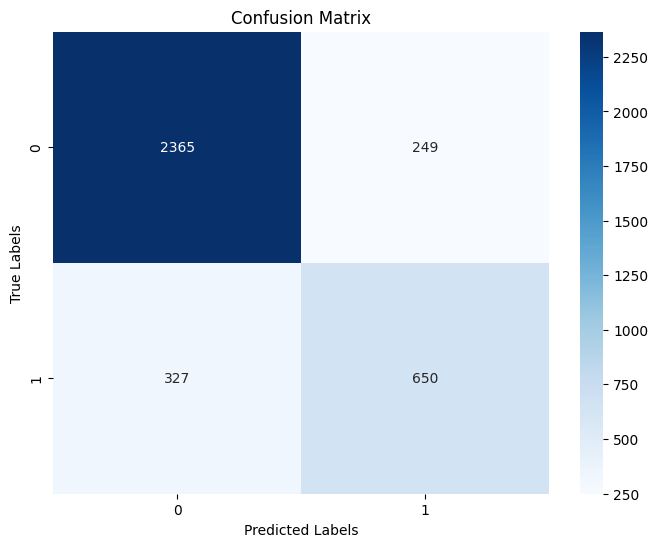

In [27]:
# Make predictions
predictions = mlp_model.predict(X_test)

threshold = 0.5
binary_predictions = np.where(predictions >= threshold, 1, 0)

# Create a confusion matrix
cm = confusion_matrix(y_test, binary_predictions)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [28]:
print(classification_report(y_test, binary_predictions))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      2614
         1.0       0.72      0.67      0.69       977

    accuracy                           0.84      3591
   macro avg       0.80      0.79      0.79      3591
weighted avg       0.84      0.84      0.84      3591



## **Merged - reviews, description and host_about non-preprocessed**

In [ ]:
airbnb_df_train

,description,host_about,unlisted
apartment_id,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0
...,...,...,...
12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,0
12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0
12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0


In [ ]:
airbnb_df_train = airbnb_df_train.rename(columns={'index': 'apartment_id'})
airbnb_df_train

,description,host_about,unlisted
apartment_id,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0
...,...,...,...
12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,0
12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0
12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0


In [ ]:
reviews_df_train = reviews_df_train.rename(columns={'index': 'apartment_id'})
reviews_df_train

,comments
apartment_id,
1,this is a very cozy and comfortable house to s...
1,good<br/>
1,"My first hostel experience, and all I have to ..."
1,Das Hostel war neu und deshalb funktionierte a...
1,"It was fine for a dorm, but I think for the pe..."
...,...
12494,"We had a good time, the apartment has a great ..."
12494,Great apartment in very central location. The ...
12494,"We are Airbnb Super Hosts too, so trust me, Li..."


In [ ]:
# Group the 'reviews_preprocessed' DataFrame by 'apartment_id' and aggregate the columns as lists
reviews_grouped = reviews_df_train.groupby('apartment_id').agg({
    'comments': str
}).reset_index()

# reviews_grouped['comments'] = reviews_grouped['comments'].apply(lambda x: [str(item) for sublist in x for item in sublist])

merged_nonpreprocessed = pd.merge(reviews_grouped, airbnb_df_train, on='apartment_id', how='right')

# Fill missing values with empty lists
merged_nonpreprocessed.fillna('', inplace=True)

In [ ]:
merged_nonpreprocessed.head()

,apartment_id,comments,description,host_about,unlisted
0,1,apartment_id\n1 this is a very cozy and com...,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,apartment_id\n5 Un très bel appartement ave...,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


### Train Test Split

In [ ]:
# Fill missing values with an empty string in the numeric columns
merged_nonpreprocessed['comments'] = merged_nonpreprocessed['comments'].fillna('')
merged_nonpreprocessed['host_about'] = merged_nonpreprocessed['host_about'].fillna('')
merged_nonpreprocessed['description'] = merged_nonpreprocessed['description'].fillna('')

# Concatenate the columns
X2 = merged_nonpreprocessed['comments'].astype(str) + merged_nonpreprocessed['host_about'].astype(str) + merged_nonpreprocessed['description'].astype(str)
y2 = merged_nonpreprocessed['unlisted']

# Split the data into train and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)


## GloVe Embeddings

In [ ]:
# Convert the input data to strings
X_train2 = X_train2.astype(str)
X_test2 = X_test2.astype(str)

max_features=10000

word_tokenizer = Tokenizer(num_words=max_features)
word_tokenizer.fit_on_texts(X_train2.tolist())
X_train2 = word_tokenizer.texts_to_sequences(X_train2.tolist())
X_test2 = word_tokenizer.texts_to_sequences(X_test2.tolist())

# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1

# Padding all reviews to fixed length 100
maxlen = 100
X_train2 = pad_sequences(X_train2, padding='post', maxlen=maxlen)
X_test2 = pad_sequences(X_test2, padding='post', maxlen=maxlen)

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.
embedding_matrix2 = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix2[index] = embedding_vector

# Print Embedding Matrix shape
embedding_matrix2.shape

(62452, 100)

In [ ]:
embedding_matrix2

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [ 0.19788   ,  0.25264999, -0.28308001, ..., -0.44062999,
        -0.74264997, -0.3215    ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## LSTM

### Training the model

In [ ]:
# Neural Network architecture
lstm_model2 = Sequential()
embedding_layer2 = Embedding(vocab_length, 100, weights=[embedding_matrix2], input_length=maxlen , trainable=False)
lstm_model2.add(embedding_layer2)
lstm_model2.add(LSTM(128))
lstm_model2.add(Dense(1, activation='sigmoid'))

# Model compiling
lstm_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model2.summary())

# Model Training
lstm_model2_history = lstm_model2.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.3)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 100)          6245200   
                                                                 
 lstm_10 (LSTM)              (None, 128)               117248    
                                                                 
 dense_26 (Dense)            (None, 1)                 129       
                                                                 
Total params: 6,362,577
Trainable params: 117,377
Non-trainable params: 6,245,200
_________________________________________________________________
None
Epoch 1/6
46/46 [==============================] - 22s 412ms/step - loss: 0.3866 - accuracy: 0.8312 - val_loss: 0.3675 - val_accuracy: 0.8481
Epoch 2/6
46/46 [==============================] - 18s 399ms/step - loss: 0.3616 - accuracy: 0.8539 - val_loss: 0.3666 - val_accuracy: 0.8473
Epoch 3/6
46

118/118 [==============================] - 7s 57ms/step - loss: 0.7699 - accuracy: 0.5996
Test Score: 0.7699323892593384
Test Accuracy: 0.5996265411376953


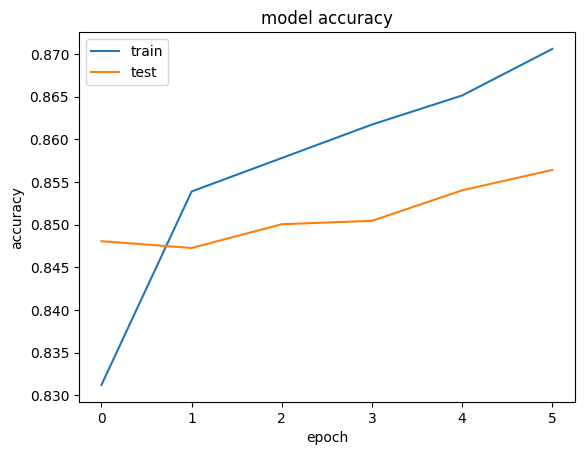

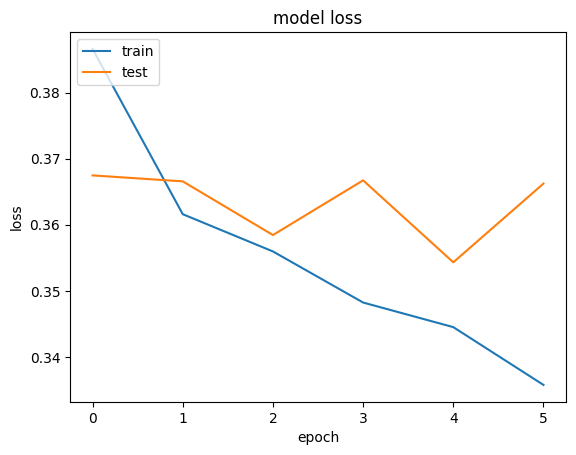

In [ ]:
# Predictions on the Test Set
score = lstm_model2.evaluate(X_test2, y_test2, verbose=1)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

# Model Performance Charts
plt.plot(lstm_model2_history.history['accuracy'])
plt.plot(lstm_model2_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model2_history.history['loss'])
plt.plot(lstm_model2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

118/118 [==============================] - 8s 64ms/step


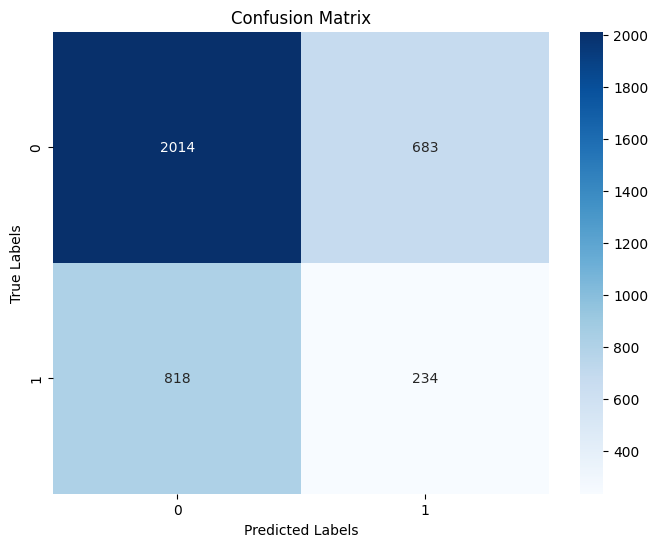

In [ ]:
# Make predictions
predictions2 = lstm_model2.predict(X_test2)

threshold = 0.5
binary_predictions2 = np.where(predictions2 >= threshold, 1, 0)

# Create a confusion matrix
cm = confusion_matrix(y_test2, binary_predictions2)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print(classification_report(y_test2, binary_predictions2))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      2697
           1       0.26      0.22      0.24      1052

    accuracy                           0.60      3749
   macro avg       0.48      0.48      0.48      3749
weighted avg       0.58      0.60      0.59      3749



## Logistic Regression

In [ ]:
# Convert the input data to strings
X_train_str2 = [" ".join(map(str, sequence)) for sequence in X_train2]
X_test_str2 = [" ".join(map(str, sequence)) for sequence in X_test2]

# Convert text data to numerical features using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized2 = vectorizer.fit_transform(X_train_str2)
X_test_vectorized2 = vectorizer.transform(X_test_str2)

# Train logistic regression model
logreg2 = LogisticRegression(max_iter=1000)
logreg2.fit(X_train_vectorized2, y_train2)

# Make predictions
predictions2 = logreg2.predict(X_test_vectorized2)

### Evaluation and Results

In [ ]:
# Calculate accuracy
accuracy = logreg2.score(X_test_vectorized2, y_test2)
print('Accuracy:', accuracy)

Accuracy: 0.7588690317417978


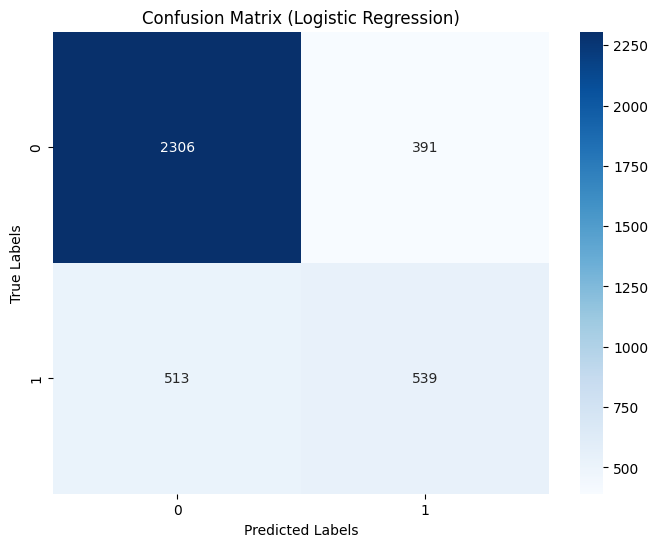

In [ ]:
# Set a threshold for converting predictions to binary values
threshold = 0.5
binary_predictions2 = np.where(predictions2 >= threshold, 1, 0)

# Create a confusion matrix
cm = confusion_matrix(y_test2, binary_predictions2)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print(classification_report(y_test2, binary_predictions2))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      2697
           1       0.58      0.51      0.54      1052

    accuracy                           0.76      3749
   macro avg       0.70      0.68      0.69      3749
weighted avg       0.75      0.76      0.75      3749



## MLP

### Training the model

In [ ]:
# MLP Model architecture with Embedding layer
mlp_model2 = Sequential()
mlp_model2.add(Embedding(vocab_length, 100, input_length=maxlen, trainable=False))
mlp_model2.add(Flatten())
mlp_model2.add(Dense(128, activation='relu'))
mlp_model2.add(Dropout(0.5))
mlp_model2.add(Dense(64, activation='relu'))
mlp_model2.add(Dropout(0.5))
mlp_model2.add(Dense(1, activation='sigmoid'))

# Model compiling
mlp_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(mlp_model2.summary())

# Model Training
mlp_model2_history = mlp_model2.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.3)


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 100)          6245200   
                                                                 
 flatten_6 (Flatten)         (None, 10000)             0         
                                                                 
 dense_27 (Dense)            (None, 128)               1280128   
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 1)               

### Evaluation and Results

118/118 [==============================] - 1s 5ms/step - loss: 1.2833 - accuracy: 0.5676
Test Score: 1.2832832336425781
Test Accuracy: 0.5676180124282837


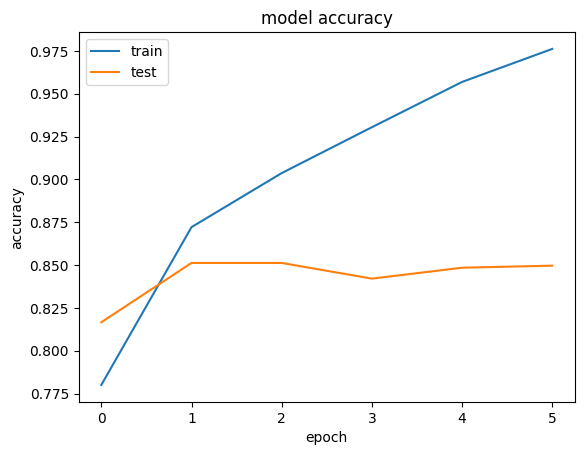

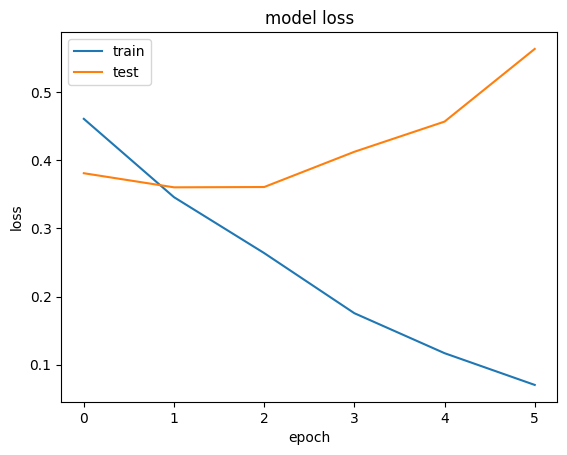

In [ ]:
# Predictions on the Test Set
score = mlp_model2.evaluate(X_test2, y_test2, verbose=1)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

# Model Performance Charts
plt.plot(mlp_model2_history.history['accuracy'])
plt.plot(mlp_model2_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(mlp_model2_history.history['loss'])
plt.plot(mlp_model2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

118/118 [==============================] - 1s 4ms/step


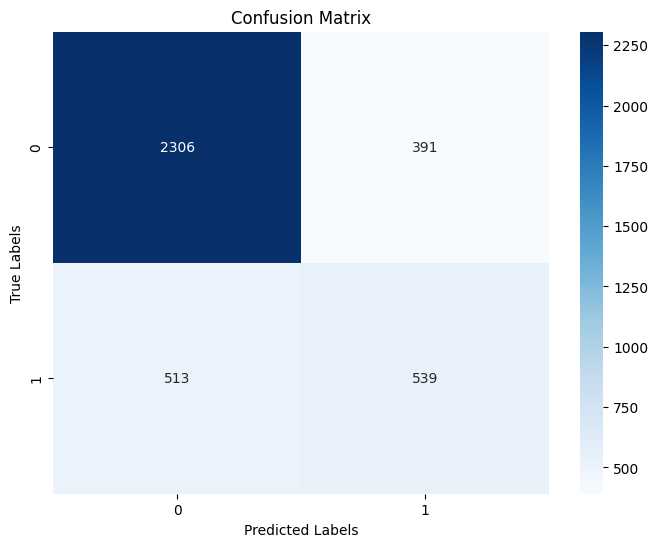

In [ ]:
# Make predictions
predictions2 = mlp_model2.predict(X_test2)

threshold = 0.5
binary_predictions = np.where(predictions2 >= threshold, 1, 0)

# Create a confusion matrix
cm = confusion_matrix(y_test2, binary_predictions2)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print(classification_report(y_test2, binary_predictions2))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      2697
           1       0.58      0.51      0.54      1052

    accuracy                           0.76      3749
   macro avg       0.70      0.68      0.69      3749
weighted avg       0.75      0.76      0.75      3749



## Test Treatment

In [ ]:
%cd /content/drive/MyDrive/Text Mining/


/content/drive/.shortcut-targets-by-id/1N9Y-dcZIQh9qUPRXgB1grO-NTXypIRl8/Text Mining


In [45]:
import pickle
with open('/content/drive/MyDrive/Text Mining/preprocessed_test_small_df.pickle', 'rb') as data:
    reviews_preprocessed_test = pickle.load(data)

In [46]:
import pickle
with open('/content/drive/MyDrive/Text Mining/preprocessed_airbnb_df_test.pickle', 'rb') as data:
    airbnb_preprocessed_test = pickle.load(data)

In [ ]:
reviews_preprocessed_test

,index,comments,language,sentiment
0,1,"[thank, antonio, perfect, stay, appartment, pe...",en,positive
1,1,"[nice, appartment, old, town, lissabon, centra...",en,positive
2,1,"[travel, look, kid, friendly, place, stay, ant...",en,positive
3,1,"[lisbon, march, adult, child, house, big, comf...",en,positive
4,1,"[host, antonio, helpful, information, lissabon...",en,positive
...,...,...,...,...
4444,1387,"[estuviser, casa, super, limpio, piso, bonito,...",es,positive
4445,1387,"[tiago, nice, guy, amazing, apartment, need, t...",en,positive
4446,1387,"[apartamento, cómodo, bonito, recién, reformad...",es,positive
4447,1388,"[unfortunately, pleasant, experience, humidity...",en,positive


In [47]:
# Group the 'reviews_preprocessed' DataFrame by 'apartment_id' and aggregate the columns as lists
reviews_grouped = reviews_preprocessed_test.groupby('index').agg({
    'comments': list,
    'sentiment': list,
    'language': list
}).reset_index()

reviews_grouped['comments'] = reviews_grouped['comments'].apply(lambda x: [item for sublist in x for item in sublist])

merged_test = pd.merge(reviews_grouped, airbnb_preprocessed_test, on='index', how='right')

# Fill missing values with empty lists
merged_test.fillna('', inplace=True)

In [48]:
merged_test['comments'] = merged_test['comments'].apply(lambda tokens: ' '.join(tokens))
merged_test['host_about'] = merged_test['host_about'].apply(lambda tokens: ' '.join(tokens))
merged_test['description'] = merged_test['description'].apply(lambda tokens: ' '.join(tokens))
merged_test['sentiment'] = merged_test['sentiment'].apply(lambda tokens: ' '.join(tokens))

X = merged_test['comments'] + merged_test['host_about'] + merged_test['description'] + merged_test['sentiment']

In [49]:
# Convert the input data to strings
X = X.astype(str)

max_features = 10000

word_tokenizer = Tokenizer(num_words = max_features)
word_tokenizer.fit_on_texts(X.tolist())
X = word_tokenizer.texts_to_sequences(X.tolist())

# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1

# Padding all reviews to fixed length 100
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)

In [50]:
embedding_matrix_test = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix_test[index] = embedding_vector

# Print Embedding Matrix shape
embedding_matrix_test.shape

(23210, 100)

In [44]:
X

array([[7263, 1454,    2, ...,  889,  350,  414],
       [ 187,  761,  753, ..., 1339, 2184,  308],
       [ 125,  194, 4326, ...,   76, 7272,   19],
       ...,
       [  49,   77, 1294, ...,  246,    4, 5289],
       [1123, 1174, 1801, ...,    6,  107,  109],
       [  24,  201,   32, ...,  143,  727,  107]], dtype=int32)

#### Our best model was the lstm with the preprocessed data


In [51]:
# Make predictions
predictions2 = lstm_model.predict(X)

42/42 [==============================] - 0s 4ms/step


In [52]:
predictions2

array([[0.3129456 ],
       [0.1296221 ],
       [0.07742015],
       ...,
       [0.07676997],
       [0.17437752],
       [0.41186905]], dtype=float32)

In [65]:
threshold = 0.4
binary_predictions = np.where(predictions2 >= threshold, 1, 0)

In [66]:
binary_predictions

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [73]:
predictions_test = airbnb_preprocessed_test.drop(['description','description_language','host_about','host_about_language'], axis=1)

In [67]:
np.unique(binary_predictions, return_counts=True)

(array([0, 1]), array([938, 393]))

In [74]:
predictions_test

,index
0,11.0
1,10.0
2,1.0
3,19.0
4,22.0
...,...
1326,1366.0
1327,1382.0
1328,1384.0
1329,1368.0


In [76]:
predictions_test['predictions'] = binary_predictions
predictions_test

,index,predictions
0,11.0,0
1,10.0,0
2,1.0,0
3,19.0,0
4,22.0,1
...,...,...
1326,1366.0,1
1327,1382.0,0
1328,1384.0,0
1329,1368.0,0


In [77]:
predictions_test.to_csv('predictions.csv',index=False,sep = ',')